# Figure

#### Author(s):
Sven Buder

#### History:
210410: Created


In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from sklearn import mixture

import seaborn as sns

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

In [2]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits')

In [3]:
# Selection basics

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['best_d'] <= 10000.) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['Energy']) &
    np.isfinite(data['age_bstep'])
)

basic_cuts_mgalpha = (
    basic_cuts &
    (data['flag_alpha_fe'] == 0) &
    (data['flag_Mg_fe'] == 0)
)

def nissen_slope_mg_fe(fe_h):
    """
    Slope [Fe/H] vs. [Mg/Fe] as estimated from 2010A%26A...511L..10N
    
    -1/12 * [Fe/H] + 1/6
    
    """
    return -0.1/1.2*(fe_h)+(0.3 - 1.6*0.1/1.2)

def nissen_slope_alpha_fe(fe_h):
    """
    Slope [Fe/H] vs. [alpha/Fe] as estimated from 2010A%26A...511L..10N
    
    -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)
    
    -1/6 * [Fe/H] + 0.7/12
    
    """
    return -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)

def total_velocity(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return np.sqrt(
            (data['best_rv'])**2 + 
            (4.7623*data['best_d']/1000.)**2 * 
            ((data['pmra'])**2 + (data['pmdec'])**2)
        )

def tangential_velocity(data):
    return (4.7623*data['best_d']/1000.)*np.sqrt((data['pmra'])**2 + (data['pmdec'])**2)

rgb = (
    (data['teff'] < 5500) &
    (data['logg'] < 3.25)
)

msto = (
    (data['teff'] >= 5350) &
    (data['logg'] >= 3.5)
)

stars_with_high_vtot = (
    basic_cuts_mgalpha & 
    (total_velocity(data) > 180)
)

stars_with_high_vtan = (
    basic_cuts_mgalpha & 
    (tangential_velocity(data) > 180)
)

preliminary_low_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.4) &
    (data['Mg_fe'] < nissen_slope_mg_fe(data['fe_h']))&
    (data['alpha_fe'] < nissen_slope_alpha_fe(data['fe_h']))
)

# Selection via [Mg/Cu] vs. [Na/Fe]
chem1 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['Mg_fe'] - data['Cu_fe'] > 0.5) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe]
chem2 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe] + [Fe/H]
chem2_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1) &
    (data['fe_h'] <= -0.5)
)


# Selection via [Mg/Mn] vs. [Al/Fe], like Das+2020 'blob' selection
chem3 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25)
)

# Selection via [Mg/Mn] vs. [Al/Fe] + [Fe/H] like Das+2020 'metal-poor blob' selection
chem3_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['fe_h'] < -0.5)
)

# Selection via L_Z and J_R like Feuillet+2020
feuillet2020 = (
    basic_cuts &
    (data['L_Z'] >= -500) &
    (data['L_Z'] <= 500) &
    (data['J_R'] >= 30**2) &
    (data['J_R'] <= 50**2)
)


# Selection via L_Z and E like Helmi+2018
helmi2018 = (
    basic_cuts & 
    (data['L_Z'] > -1500) &
    (data['L_Z'] < 150) &
    (data['Energy'] > -1.8*10**5)
)

# Selection like Naidu+2020, excluding Sagitarius, Alpeh, high-alpha disk and then selection via eccentricity
#naidu2020_sagitarius = (data['L_Y'] < -0.3*data['L_Z'] - 2.5*10**3)
naidu2020_aleph = (
    (data['vT_Rzphi'] < -175) &
    (data['vT_Rzphi'] > 300) & 
    (np.abs(data['vR_Rzphi']) < 75) & 
    (data['fe_h'] > -0.8) & 
    (data['alpha_fe'] < 0.27)
)
naidu2020_highalphadisk = (
    (data['alpha_fe'] > 0.25 - 0.5*(data['fe_h'] + 0.7))
)
naidu2020 = (
    basic_cuts & 
    (data['flag_fe_h'] == 0) &
    (data['flag_alpha_fe'] == 0) &
    # Sagitarius
    (~naidu2020_aleph) &
    (~naidu2020_highalphadisk) &
    (data['ecc'] > 0.7)
)

In [8]:
samples = [preliminary_low_alpha_halo, chem1,chem2,chem2_mp,chem3,chem3_mp,naidu2020,feuillet2020,helmi2018]

in_any = np.any(samples,axis=0)

print('LAH: Preliminary low-alpha-halo')
print('Chem 1: [Mg/Cu] vs. [Na/Fe]')
print('Chem 2: [Mg/Mn] vs. [Na/Fe]')
print('Chem 2 MP: [Mg/Mn] vs. [Na/Fe], [Fe/H] < -0.5')
print('Chem 3: [Mg/Mn] vs. [Al/Fe]')
print('Chem 3 MP: [Mg/Mn] vs. [Al/Fe], [Fe/H] < -0.5')

correlation = []
labels = ['LAH', 'Chem 1','Chem 2','Chem 2 MP', 'Chem 3','Chem 3 MP','Feuillet+20','Naidu+20','Helmi+18']

def selected_stars():
    
    selected_stars = Table()
    selected_stars['sobject_id'] = data['sobject_id'][in_any]
    selected_stars['dr3_source_id'] = data['dr3_source_id_1'][in_any]
    
    for each_ind, each in enumerate(samples):
        
        zero_one = np.zeros(len(data['sobject_id']),dtype=int)
        zero_one[each] = 1
        zero_one[in_any]

        selected_stars[labels[each_ind]] = zero_one[in_any]
    return(selected_stars)

selected_stars = selected_stars()

def get_selected_stars_table(selected_stars):
    
    groups = 'sobject\_id & dr3\_source\_id '
    dots = '\dots & \dots '
    for each in labels:
        groups = groups+' & '+each
        dots = dots+' & \dots '
    groups = groups+' \\\\'
    dots = dots+' \\\\'
    
    lines = []
    for each_line in range(4):
        line = str(selected_stars['sobject_id'][each_line])
        for each in selected_stars.keys()[1:]:
            line = line+' & '+str(selected_stars[each][each_line])
        line = line+' \\\\'
        lines.append(line)
    lines = np.array(lines)
    
    text = np.array([
        ['\\begin{table*}'],
        ['\\centering'],
        ['\\caption{Stars/Spectra selected by the different selection techniques as listed in Tab.~\\ref{tab:chemical_choices} for the chemical selection or Tab.~\\ref{tab:dynamical_choices} for the dynamical selection. The full table is available online.}'],
        ['\\label{tab:selected_stars}'],
        ['\\begin{tabular}{ccccccccccc}'],
        ['   \\hline'],
        [groups],
        ['   \\hline'],
        [lines[0]],
        [lines[1]],
        [lines[2]],
        #[lines[3]],
        [dots],
        ['   \\hline'],
        ['\\end{tabular}'],
        ['\\end{table*}']
        ])
    print(text)
    np.savetxt('../tables/selected_stars.tex',np.array(text),fmt='%s')

get_selected_stars_table(selected_stars)

LAH: Preliminary low-alpha-halo
Chem 1: [Mg/Cu] vs. [Na/Fe]
Chem 2: [Mg/Mn] vs. [Na/Fe]
Chem 2 MP: [Mg/Mn] vs. [Na/Fe], [Fe/H] < -0.5
Chem 3: [Mg/Mn] vs. [Al/Fe]
Chem 3 MP: [Mg/Mn] vs. [Al/Fe], [Fe/H] < -0.5
[['\\begin{table*}']
 ['\\centering']
 ['\\caption{Stars/Spectra selected by the different selection techniques as listed in Tab.~\\ref{tab:chemical_choices} for the chemical selection or Tab.~\\ref{tab:dynamical_choices} for the dynamical selection. The full table is available online.}']
 ['\\label{tab:selected_stars}']
 ['\\begin{tabular}{ccccccccccc}']
 ['   \\hline']
 ['sobject\\_id & dr3\\_source\\_id  & LAH & Chem 1 & Chem 2 & Chem 2 MP & Chem 3 & Chem 3 MP & Feuillet+20 & Naidu+20 & Helmi+18 \\\\']
 ['   \\hline']
 ['131116000501004 & 4667324643983679744 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\\\']
 ['131116000501014 & 4667315779171681536 & 1 & 0 & 1 & 1 & 0 & 0 & 1 & 0 & 0 \\\\']
 ['131116000501059 & 4667295055952796800 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\\\']
 ['\\dots & \

In [5]:
[len(data['sobject_id'][each_column]) for each_column in samples]

[5021, 3190, 8092, 4195, 1541, 725, 6230, 1383, 3476]

In [6]:
labels

['LAH',
 'Chem 1',
 'Chem 2',
 'Chem 2 MP',
 'Chem 3',
 'Chem 3 MP',
 'Feuillet+20',
 'Naidu+20',
 'Helmi+18']

This asymmetric table can be read in the following way: The overlap between ``LAH'' and `` Chem 1'' is 1749 spectra. That is 35\% of ``LAH'' (5021 spetra) and 55\% of ``Chem 1'' (3190 spetra).


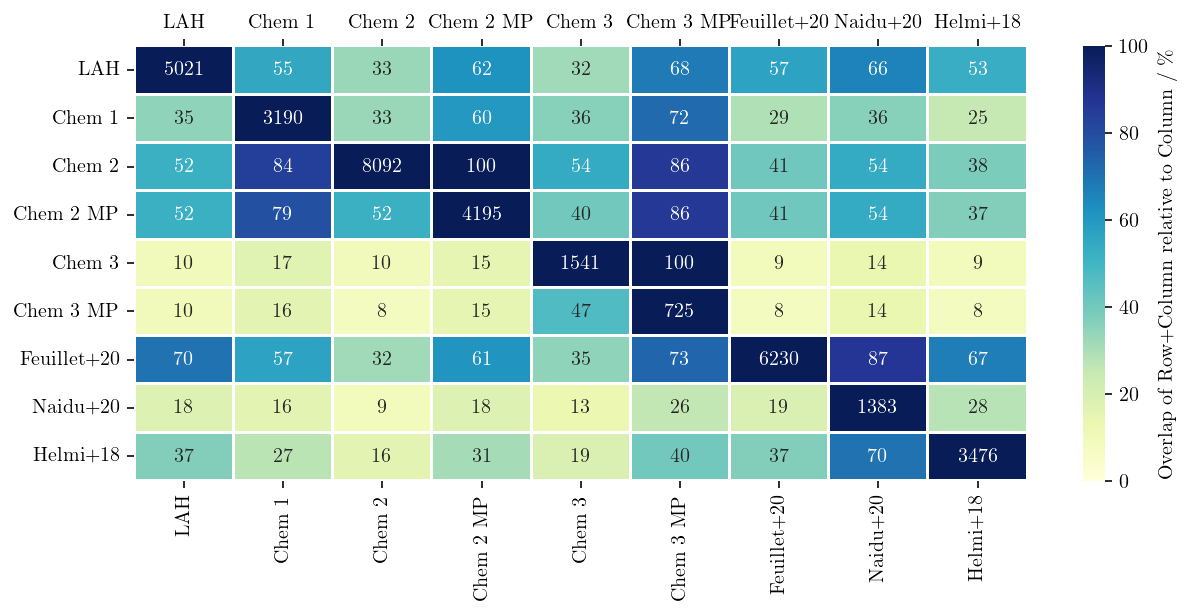

In [7]:
def plot_heat_map():
    """
    
    """
    
    # Print how it works:
    cell_0_1 = len(data['sobject_id'][(samples[0] & samples[1])])
    group0 = len(data['sobject_id'][(samples[0])])
    group1 = len(data['sobject_id'][(samples[1])])
    
    explanation = "This asymmetric table can be read in the following way: The overlap between ``"+labels[0]+"'' and `` "+labels[1]+"'' is "+str(cell_0_1)+" spectra. That is "+str(int(np.round(100*cell_0_1/group0)))+"\\% of ``"+labels[0]+"'' ("+str(group0)+" spetra) and "+str(int(np.round(100*cell_0_1/group1)))+"\\% of ``"+labels[1]+"'' ("+str(group1)+" spetra)."
    print(explanation)
    np.savetxt('../depending_text/correlation_explanation.tex',[explanation],fmt='%s')
    
    correlation = []

    for e_c, each_column in enumerate(samples):

        column_number = len(data['sobject_id'][each_column])

        column = []

        for e_r, each_row in enumerate(samples):

            cell_number = len(data['sobject_id'][(each_column & each_row)])

            if e_r == e_c:
                column.append(cell_number)
            else:
                column.append(np.round(100*cell_number/column_number))

        correlation.append(column)

    f, ax = plt.subplots(figsize=(10, 4))
    ax = sns.heatmap(
        np.array(correlation).T, 
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        cbar_kws={'label': r'Overlap of Row+Column relative to Column / \%'},
        fmt='.0f', vmin=0, vmax=100, annot=True, cmap="YlGnBu")
    ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
    ax.tick_params(top=True, labeltop=True)

    plt.savefig('selection_overlap.png',dpi=300,bbox_inches='tight')

plot_heat_map()